In [ ]:
# ARIMA模型的石油价格短期分析

# 要求：
# 1.季节周期性检验，要图
# 2.平稳性检验：自相关和偏相关分析，要图 Autocorrelation /Partial Correlation
# 3.差分阶数确定：做一阶差分和二阶差分，要图，接下来确定几组ARIMA（p,d,q），不要系统自动生成的阶数
# 4.利用上述几组ARIMA模型，分别做结果和参数预测，要图和表
# 5.做确定阶数的时候，多换几组数，找个预测结果比较好的，用模型检验近期数据，误差最小的

In [186]:
import pandas as pd
import numpy as np

In [7]:
raw_data = pd.read_csv('WTI_history.csv')
raw_data.head()

,日期,收盘,开盘,高,低,交易量,百分比变化
0,2019年1月28日,52.12,53.28,53.62,51.95,-,-2.16%
1,2019年1月27日,53.27,53.59,53.64,53.27,-,-0.78%
2,2019年1月25日,53.69,53.17,53.94,52.91,593.39K,1.05%
3,2019年1月24日,53.13,52.45,53.47,52.07,714.42K,0.97%
4,2019年1月23日,52.62,52.95,53.64,51.86,702.87K,0.10%


In [8]:
raw_data = pd.read_csv('WTI_history.csv')
#将数据的不要的column去除
raw_data.drop(['开盘','高','低','交易量','百分比变化'], axis=1, inplace=True)
#将数据反过来
raw_data = raw_data.reindex(index=raw_data.index[::-1])
raw_data.reset_index(drop=True, inplace=True)
#将数据的column名做变化
raw_data.columns = ['date','end_price']
#将数据的日期做处理（仅对交易日做排序）
raw_data['trade_day'] = raw_data.index

In [9]:
raw_data.head()

,date,end_price,trade_day
0,2000年1月4日,25.55,0
1,2000年1月5日,24.91,1
2,2000年1月6日,24.78,2
3,2000年1月7日,24.22,3
4,2000年1月10日,24.67,4


In [10]:
raw_data.tail()

,date,end_price,trade_day
4846,2019年1月23日,52.62,4846
4847,2019年1月24日,53.13,4847
4848,2019年1月25日,53.69,4848
4849,2019年1月27日,53.27,4849
4850,2019年1月28日,52.12,4850


In [22]:
date_transfer_df = raw_data[['date','trade_day']]

In [23]:
date_transfer_df['new_date']=pd.date_range('1970-01-01', periods=len(raw_data), freq='D')

In [24]:
date_transfer_df.head()

,date,trade_day,new_date
0,2000年1月4日,0,1970-01-01
1,2000年1月5日,1,1970-01-02
2,2000年1月6日,2,1970-01-03
3,2000年1月7日,3,1970-01-04
4,2000年1月10日,4,1970-01-05


In [25]:
raw_data.index = pd.date_range('1970-01-01', periods=len(raw_data), freq='D')
raw_data.drop(['date','trade_day'], axis=1, inplace=True)

In [26]:
raw_data.head()

,end_price
1970-01-01,25.55
1970-01-02,24.91
1970-01-03,24.78
1970-01-04,24.22
1970-01-05,24.67


In [109]:
raw_data.tail()

,end_price
1983-04-09,52.62
1983-04-10,53.13
1983-04-11,53.69
1983-04-12,53.27
1983-04-13,52.12


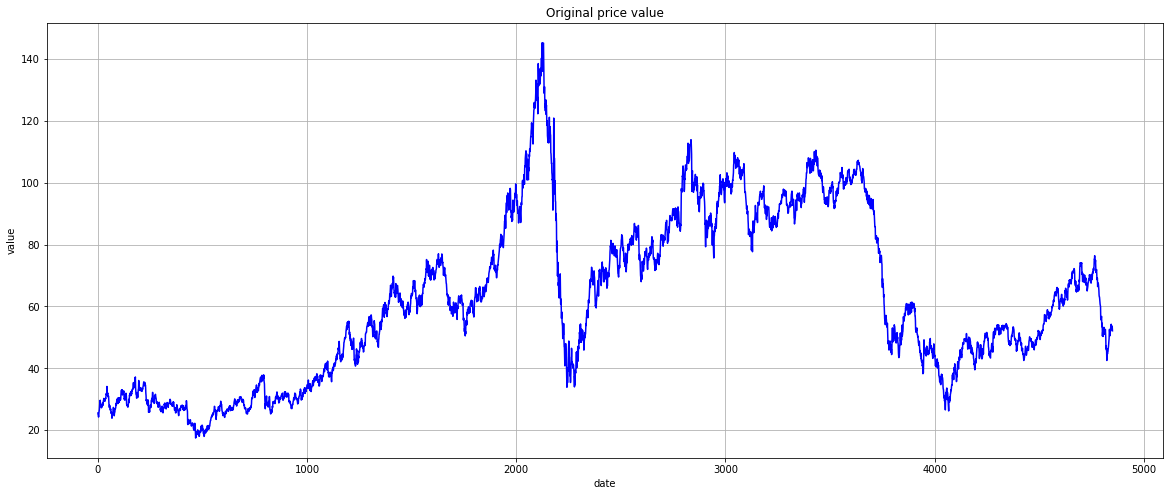

In [187]:
#作图
import matplotlib.pyplot as plt
plt_index = range(len(raw_data))
plt.figure(figsize=(20,8))
plt.plot(plt_index, raw_data['end_price'],c = 'blue')
plt.axis()
plt.title("Original price value")
plt.xlabel("date")
plt.ylabel("value")
plt.grid()
plt.savefig("Original_Price_value.png")
plt.show()

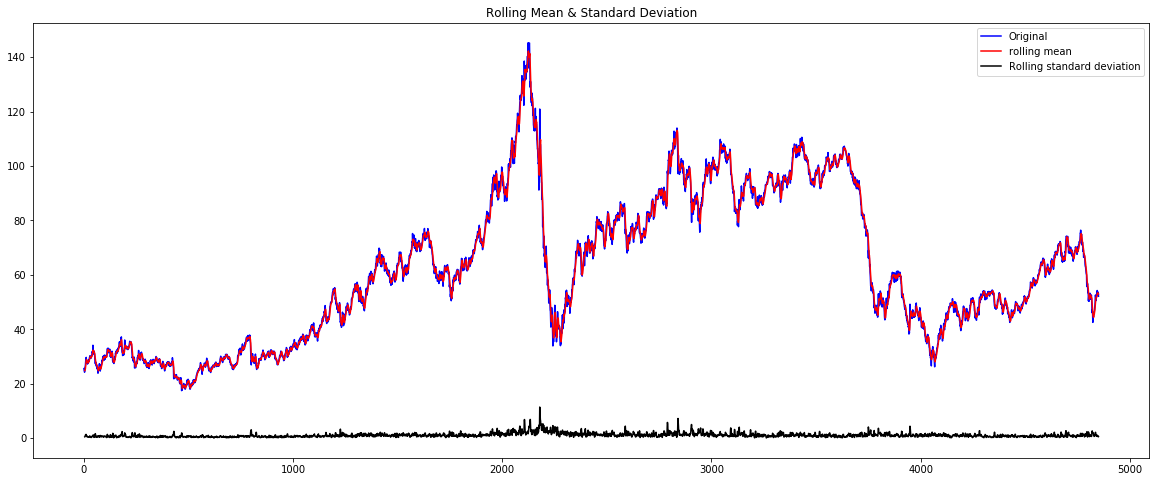

Results of Dickey-Fuller Test:
Test Statistic                   -1.971305
p-value                           0.299295
#Lags Used                        5.000000
Number of Observations Used    4845.000000
Critical value (1%)              -3.431700
Critical value (5%)              -2.862137
Critical value (10%)             -2.567088
dtype: float64


In [188]:
from statsmodels.tsa.stattools import adfuller
import matplotlib as mpl
def test_stationarity(timeseries):
    
    #这里以一周为一个窗口，每一个时间t的值由它前面5天（包括自己）的均值代替，标准差同理。
    rolmean = timeseries.rolling(5).mean()
    rolstd = timeseries.rolling(5).std()
    #pd.rolling_std(timeseries, window=7)
    #plot rolling statistics:
    fig = plt.figure(figsize=(20,8))
    fig.add_subplot()
    orig = plt.plot(range(len(timeseries)), timeseries, color = 'blue',label='Original')
    mean = plt.plot(range(len(timeseries)), rolmean , color = 'red',label = 'rolling mean')
    std = plt.plot(range(len(timeseries)), rolstd, color = 'black', label= 'Rolling standard deviation')
    
#     ax = plt.gca()
#     date_format = mpl.dates.DateFormatter("%Y-%m-%d")
#     ax.xaxis.set_major_formatter(date_format)
#     fig.autofmt_xdate() 
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.savefig("Rolling Mean% Standard Deviation.png")
    plt.show(block=False)
    
    
    #Dickey-Fuller test:
    
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries,autolag = 'AIC')
    #dftest的输出前一项依次为检测值，p值，滞后数，使用的观测数，各个置信度下的临界值
    dfoutput = pd.Series(dftest[0:4],index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical value (%s)' %key] = value
    
    print (dfoutput)
    
ts = raw_data['end_price']
test_stationarity(ts)

In [189]:
from statsmodels.tsa.seasonal import seasonal_decompose
def decompose_trend(timeseries, frequency = 250):
    # 返回包含三个部分 trend（趋势部分） ， seasonal（季节性部分） 和residual (残留部分)
    decomposition = seasonal_decompose(timeseries, freq = frequency)
    trend = decomposition.trend
    
    fig = plt.figure(figsize=(20,8))
    plt.plot(range(len(timeseries)), trend ,color = 'blue')
    plt.title('Decompose Trend %d days'%frequency)
    plt.show()
    plt.savefig('Decompose Trend %d days'%frequency)
    return (trend)

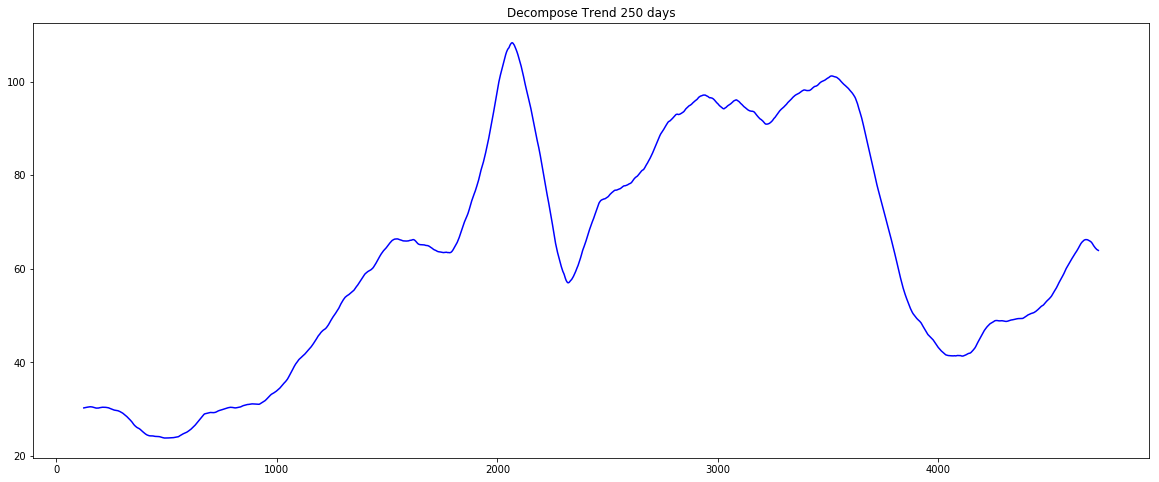

<Figure size 432x288 with 0 Axes>

In [190]:
year_trend = decompose_trend(ts, 250)

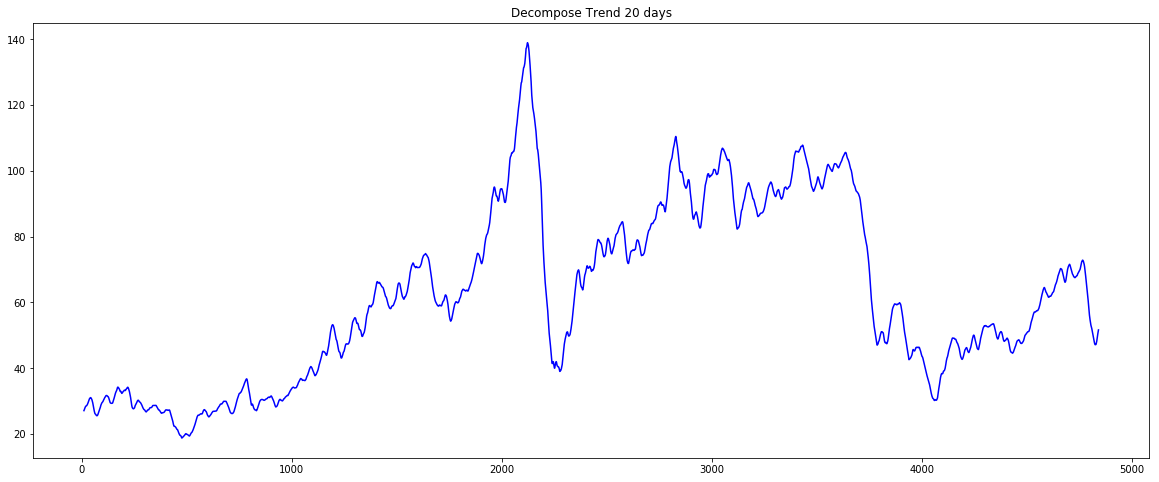

<Figure size 432x288 with 0 Axes>

In [191]:
month_trend = decompose_trend(ts, 20)

In [193]:
def decompose_seasonal(timeseries, frequency = 250):
    # 返回包含三个部分 trend（趋势部分） ， seasonal（季节性部分） 和residual (残留部分)
    decomposition = seasonal_decompose(timeseries, freq = frequency)
    seasonal = decomposition.seasonal
    
    fig = plt.figure(figsize=(20,8))
    plt.plot(range(len(timeseries)), seasonal ,color = 'blue')
    plt.title('Decompose Seasonal %d days'%frequency)
    plt.show()
    plt.savefig('Decompose Seasonal %d days'%frequency)
    return (seasonal)

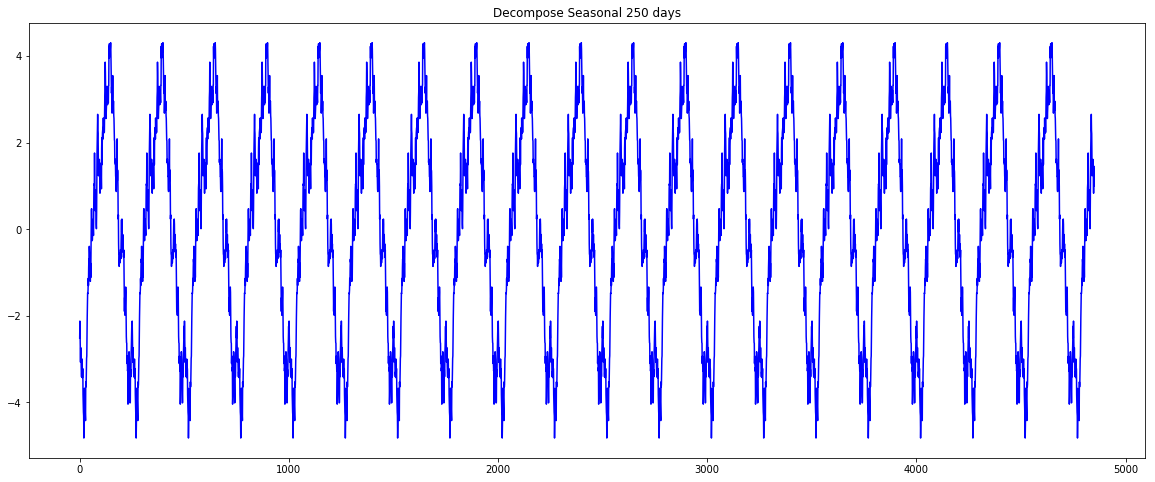

<Figure size 432x288 with 0 Axes>

In [194]:
year_seasonal= decompose_seasonal(ts, 250)

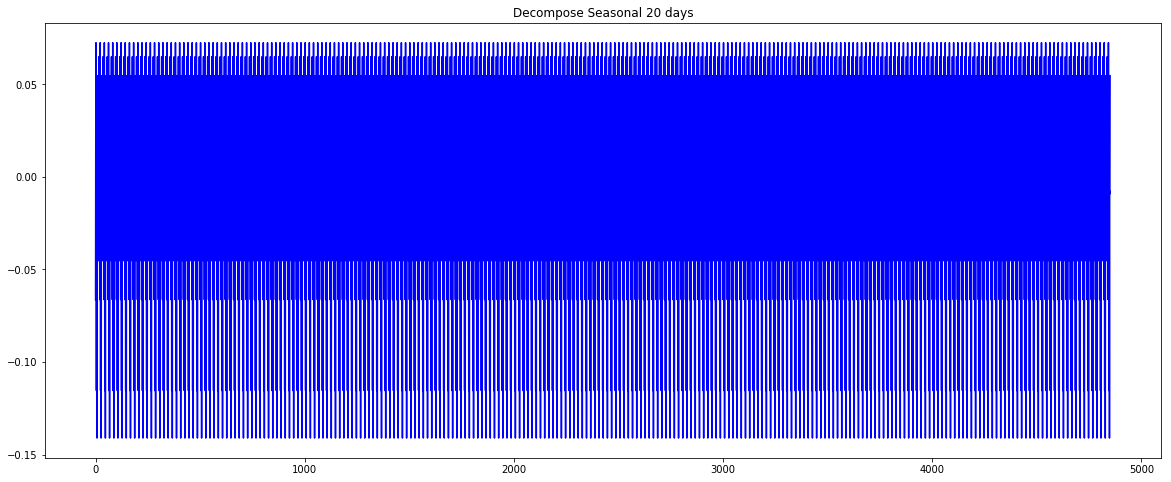

<Figure size 432x288 with 0 Axes>

In [195]:
month_seasonal = decompose_seasonal(ts, 20)

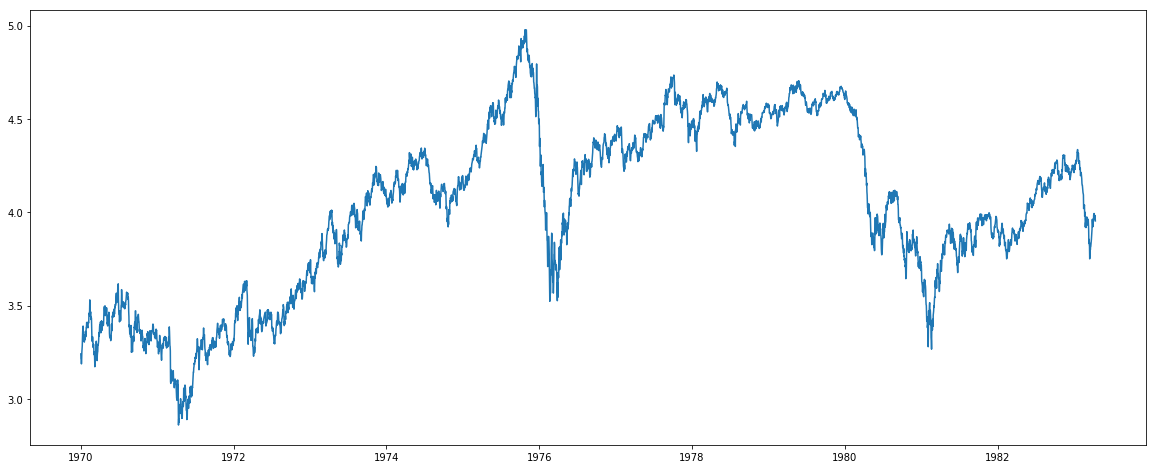

In [61]:
#将数据做log操作，但是发现效果一般
plt.figure(figsize=(20,8))
ts_log = np.log(ts)
plt.plot(ts_log)

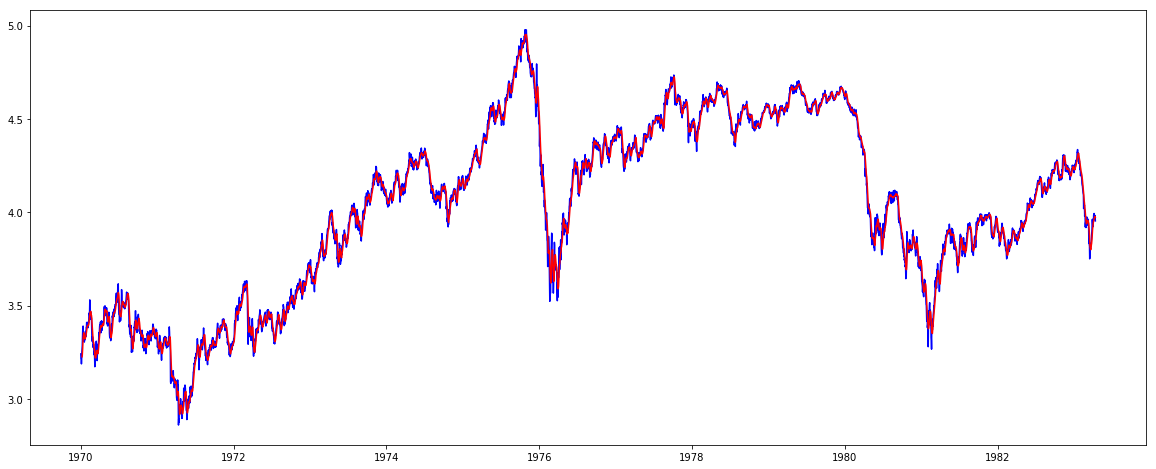

In [196]:
#moving_avg
moving_avg = ts_log.rolling(7).mean()
plt.figure(figsize=(20,8))
plt.plot(ts_log ,color = 'blue')
plt.plot(moving_avg, color='red')
plt.savefig('moving_average')

In [65]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)

1970-01-01         NaN
1970-01-02         NaN
1970-01-03         NaN
1970-01-04         NaN
1970-01-05         NaN
1970-01-06         NaN
1970-01-07    0.043561
1970-01-08    0.052806
1970-01-09    0.084629
1970-01-10    0.092095
1970-01-11    0.087364
1970-01-12    0.065102
Freq: D, Name: end_price, dtype: float64

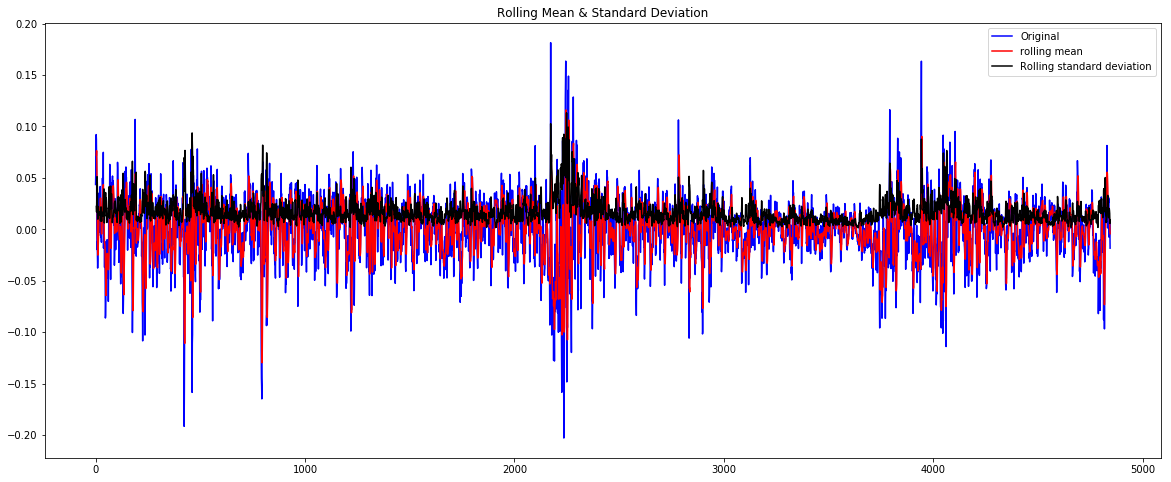

Results of Dickey-Fuller Test:
Test Statistic                  -21.040898
p-value                           0.000000
#Lags Used                        7.000000
Number of Observations Used    4837.000000
Critical value (1%)              -3.431703
Critical value (5%)              -2.862138
Critical value (10%)             -2.567088
dtype: float64


In [197]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

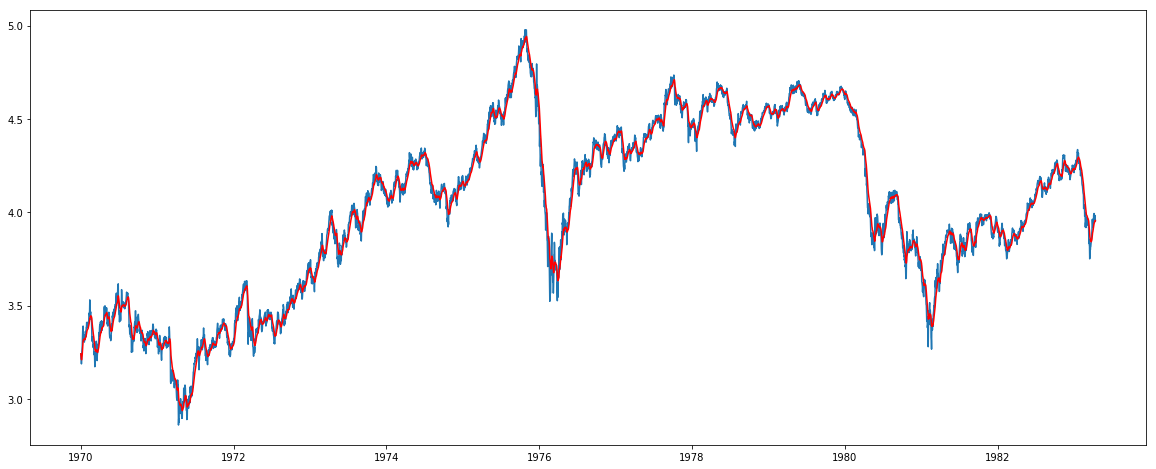

In [70]:
expwighted_avg = ts_log.ewm(halflife=5).mean()
plt.figure(figsize=(20,8))
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

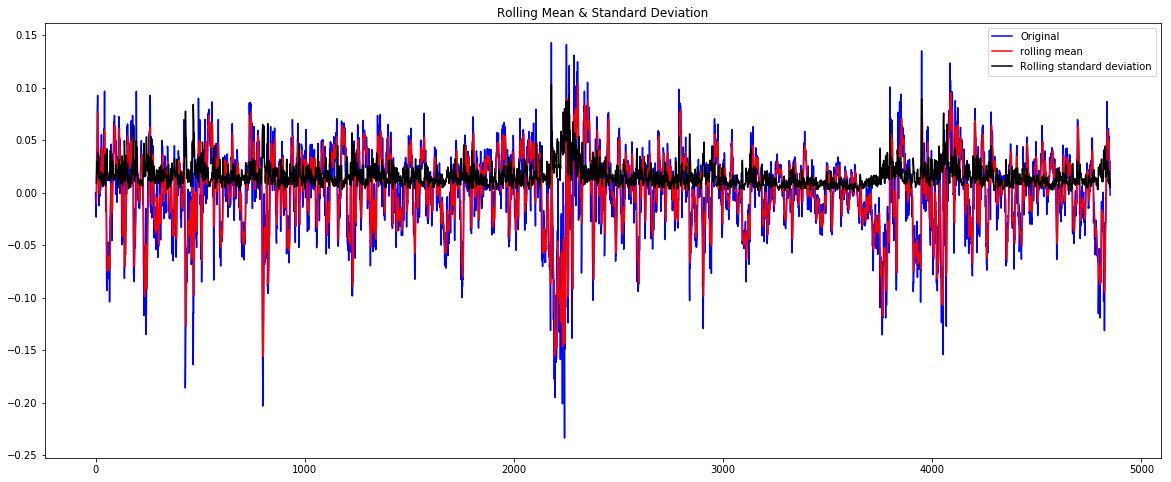

Results of Dickey-Fuller Test:
Test Statistic                -1.349342e+01
p-value                        3.074626e-25
#Lags Used                     9.000000e+00
Number of Observations Used    4.841000e+03
Critical value (1%)           -3.431702e+00
Critical value (5%)           -2.862137e+00
Critical value (10%)          -2.567088e+00
dtype: float64


In [198]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

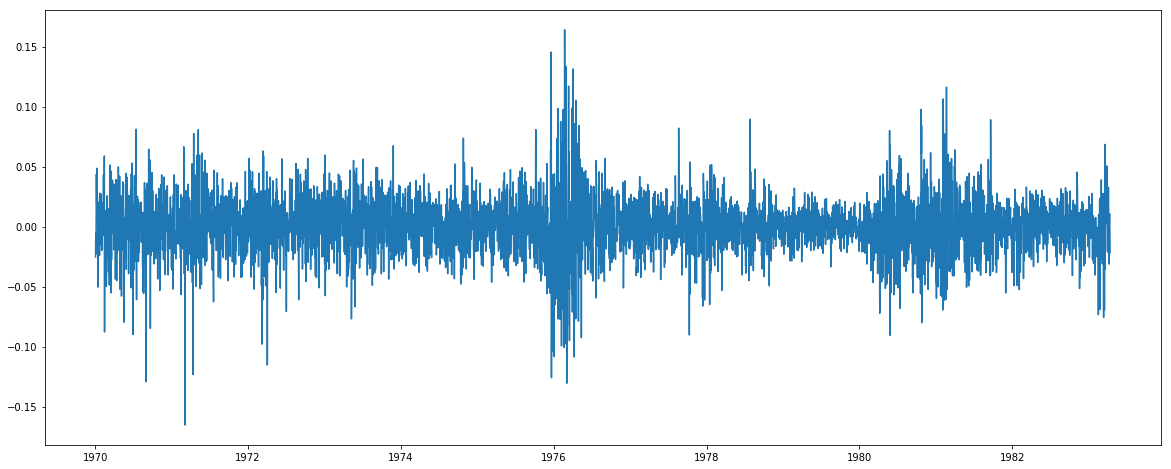

In [73]:
ts_log_diff = ts_log - ts_log.shift()
plt.figure(figsize=(20,8))
plt.plot(ts_log_diff)

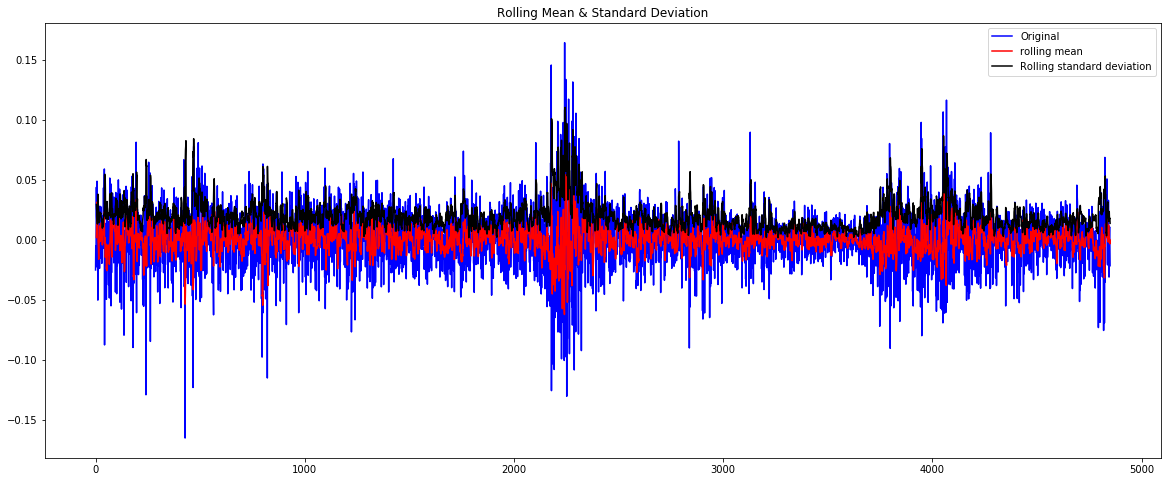

Results of Dickey-Fuller Test:
Test Statistic                  -29.940356
p-value                           0.000000
#Lags Used                        5.000000
Number of Observations Used    4844.000000
Critical value (1%)              -3.431701
Critical value (5%)              -2.862137
Critical value (10%)             -2.567088
dtype: float64


In [199]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

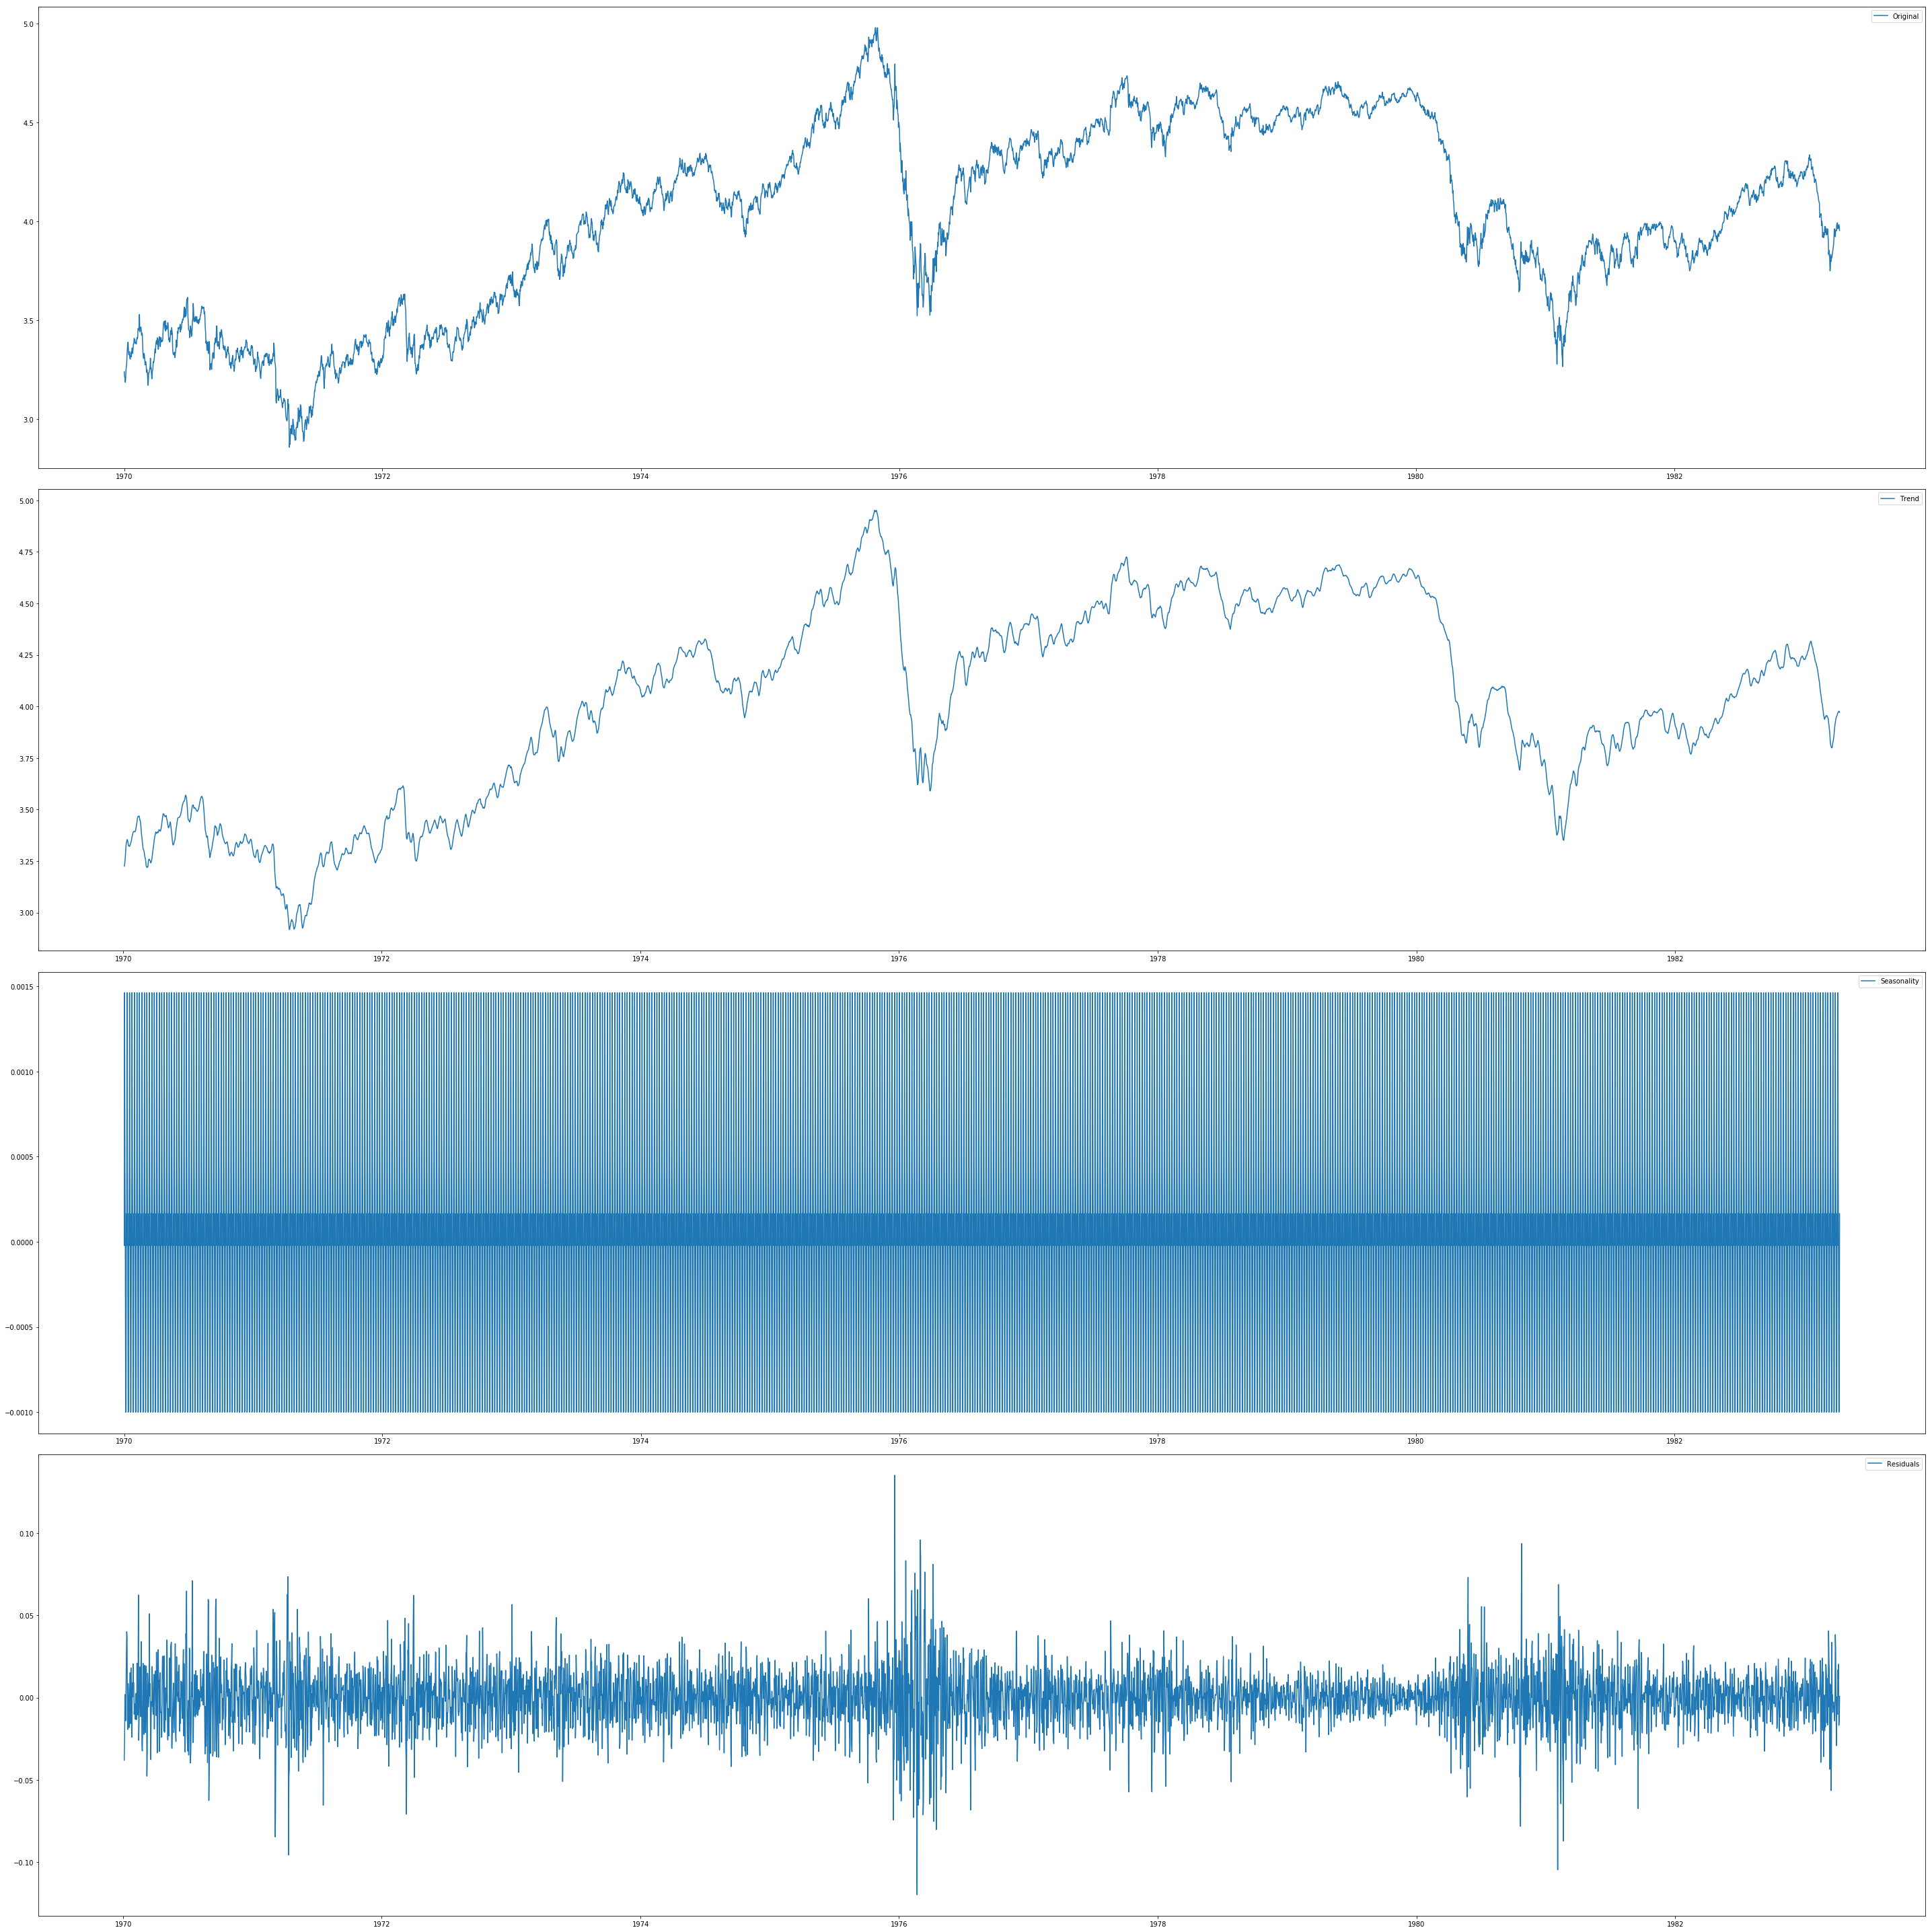

In [79]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(40,40))
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

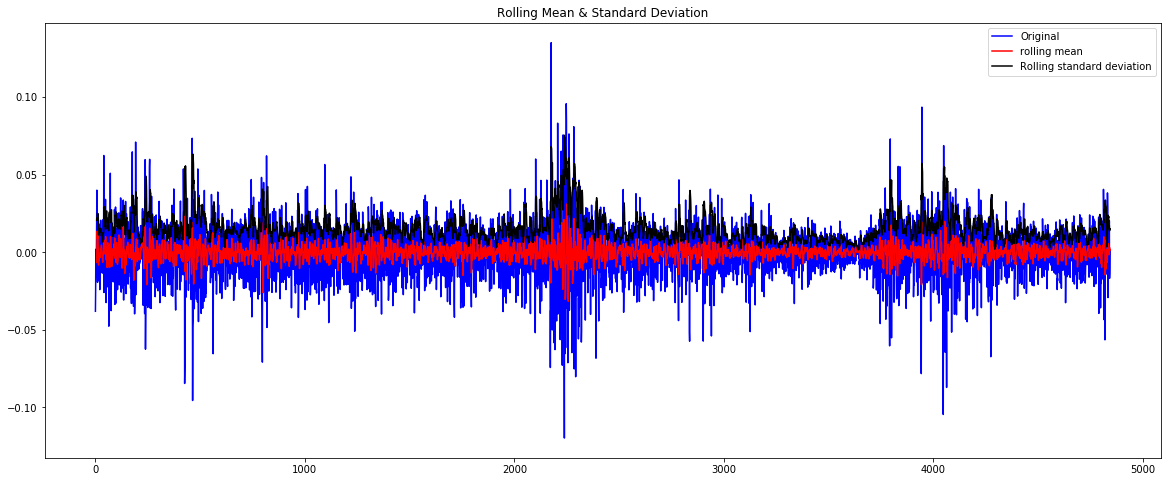

Results of Dickey-Fuller Test:
Test Statistic                  -20.027406
p-value                           0.000000
#Lags Used                       32.000000
Number of Observations Used    4812.000000
Critical value (1%)              -3.431710
Critical value (5%)              -2.862141
Critical value (10%)             -2.567090
dtype: float64


In [83]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

In [84]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

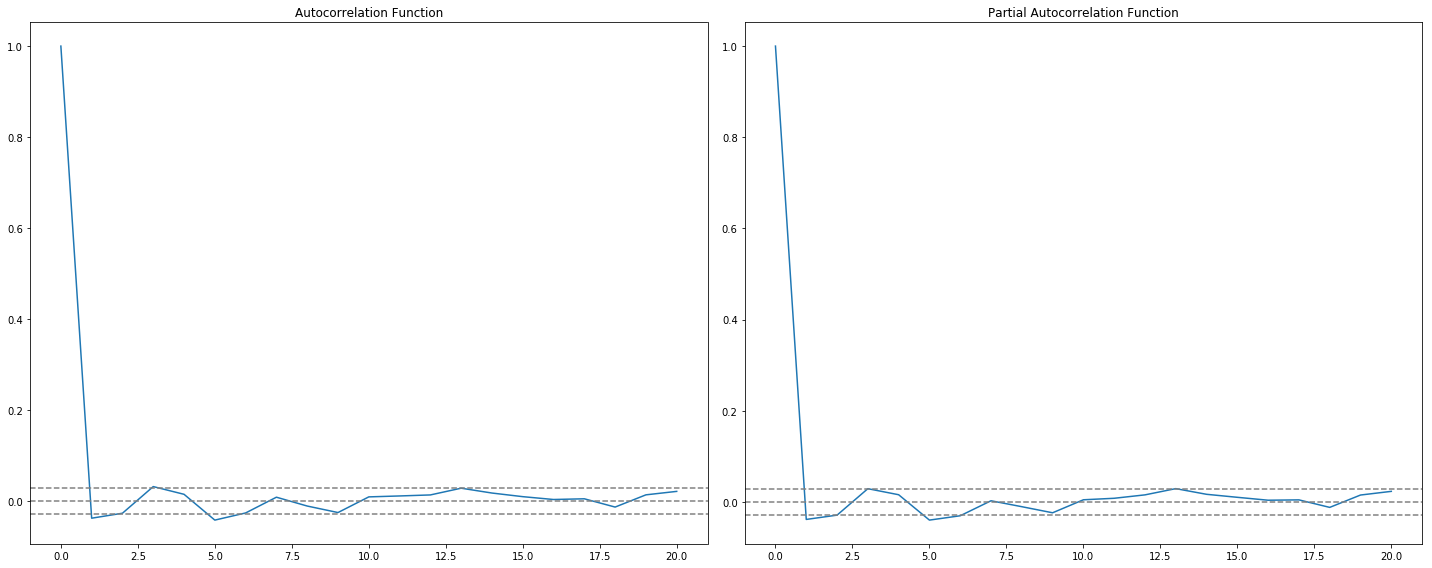

In [200]:
#Plot ACF: 
plt.figure(figsize=(20,8))
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
plt.savefig('ACF_PACF')

In [ ]:
#p – The lag value where the PACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case p=1.
#q – The lag value where the ACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case q=1.

In [87]:
from statsmodels.tsa.arima_model import ARIMA

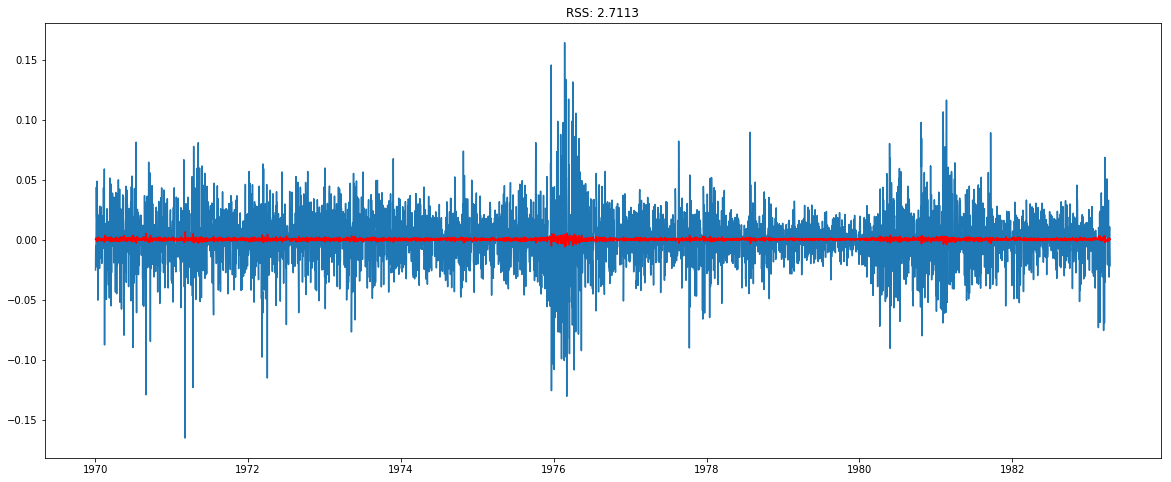

In [201]:
#AR Model
model = ARIMA(ts_log, order=(1, 1, 0))  
results_AR = model.fit(disp=-1)
plt.figure(figsize=(20,8))
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))
plt.savefig('AR')

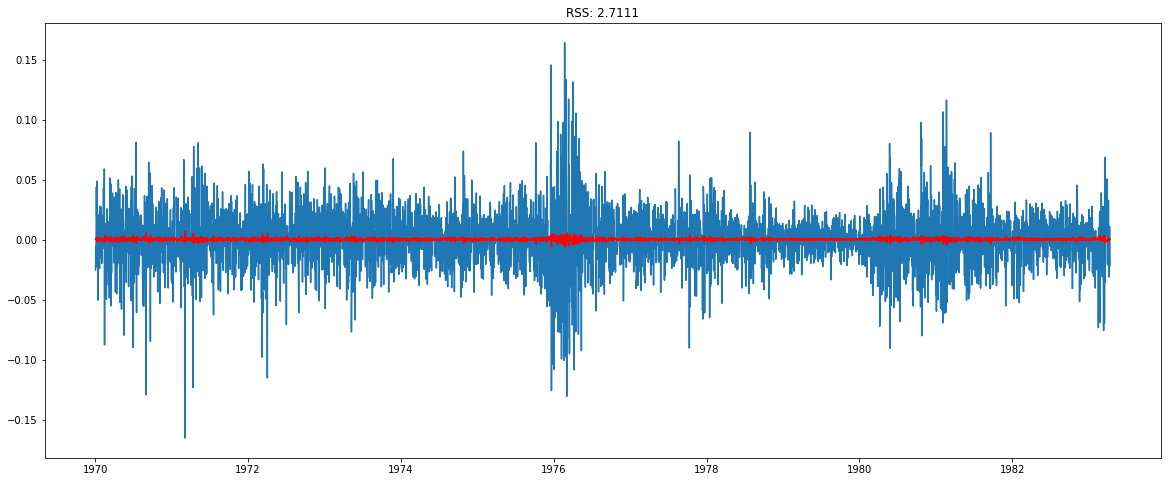

In [202]:
#MA Model
model = ARIMA(ts_log, order=(0, 1, 1))  
results_MA = model.fit(disp=-1) 
plt.figure(figsize=(20,8))
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))
plt.savefig('MA')

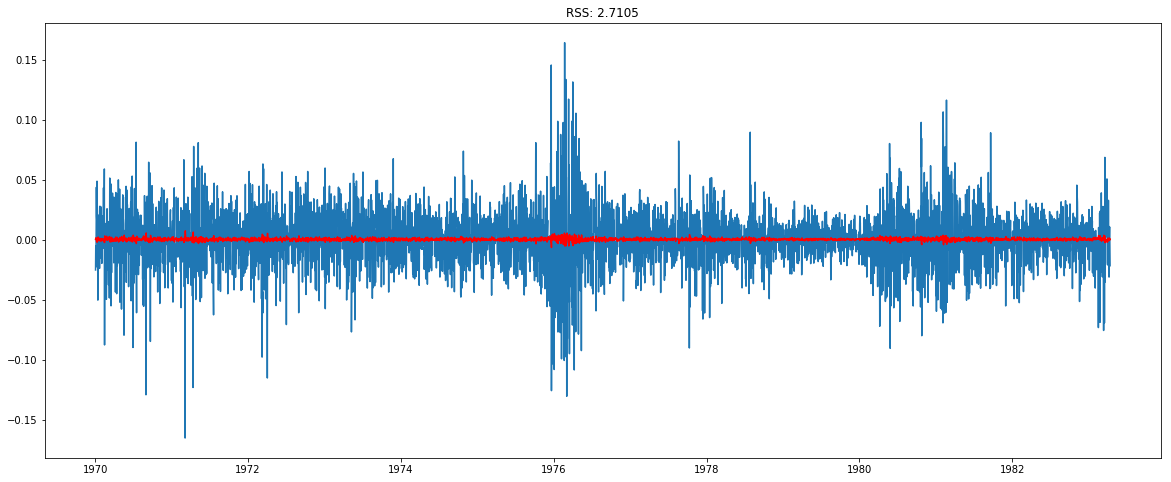

In [203]:
#Combined Model
model = ARIMA(ts_log, order=(1, 1, 1))  
results_ARIMA = model.fit(disp=-1)
plt.figure(figsize=(20,8))
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))
plt.savefig('ARIMA')

In [94]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())

1970-01-02    0.000148
1970-01-03    0.001179
1970-01-04    0.000653
1970-01-05    0.001229
1970-01-06   -0.000301
Freq: D, dtype: float64


In [95]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print (predictions_ARIMA_diff_cumsum.head())

1970-01-02    0.000148
1970-01-03    0.001327
1970-01-04    0.001979
1970-01-05    0.003208
1970-01-06    0.002907
Freq: D, dtype: float64


In [97]:
predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

1970-01-01    3.240637
1970-01-02    3.240785
1970-01-03    3.241964
1970-01-04    3.242617
1970-01-05    3.243845
Freq: D, dtype: float64

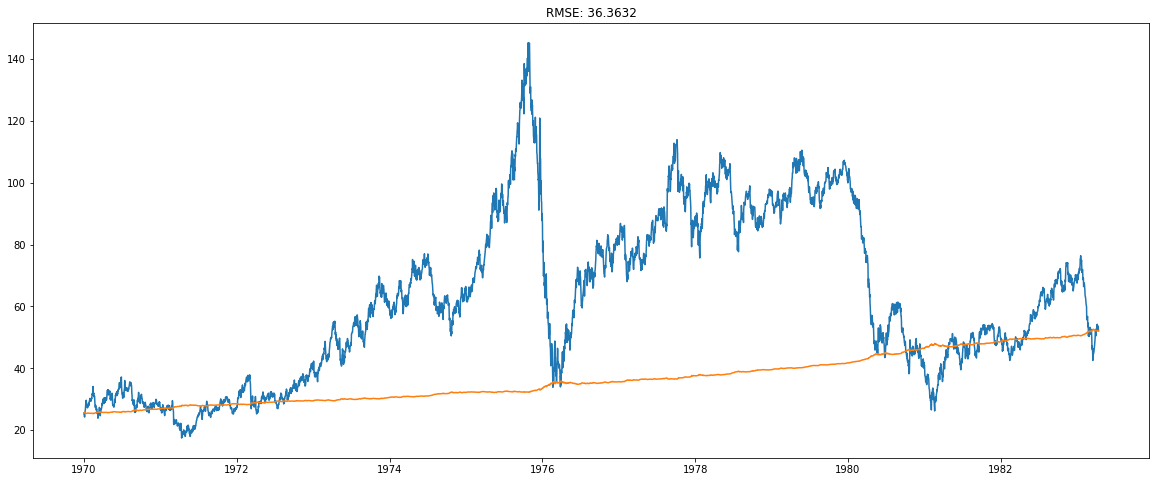

In [204]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.figure(figsize=(20,8))
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))
plt.savefig('ARIMA_all')

In [145]:
#pdq (1,1,1)
test_range = 200
test_result = []
test_prediction = []
date_for_prediction = ts[-(test_range):].index
for i in range(test_range):
    train_data = ts[:-(test_range-i)]
    #Combined Model
    model = ARIMA(train_data, order=(1, 1, 1))  
    results_ARIMA = model.fit(disp=-1)
    pre_data = results_ARIMA.predict(start=str(date_for_prediction[i]).split()[0],end=str(date_for_prediction[i]).split()[0],dynamic=True,typ='levels')
    test_prediction.append(pre_data.values[0])
#     plt.figure(figsize=(20,8))
#     plt.plot(ts_log_diff)
#     plt.plot(results_ARIMA.fittedvalues, color='red')
#     plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))
result_raw111 = ts[-(test_range):].to_frame()
result_raw111['prediction'] = test_prediction
plt.figure(figsize=(20,8))
plt.plot(result_raw111)

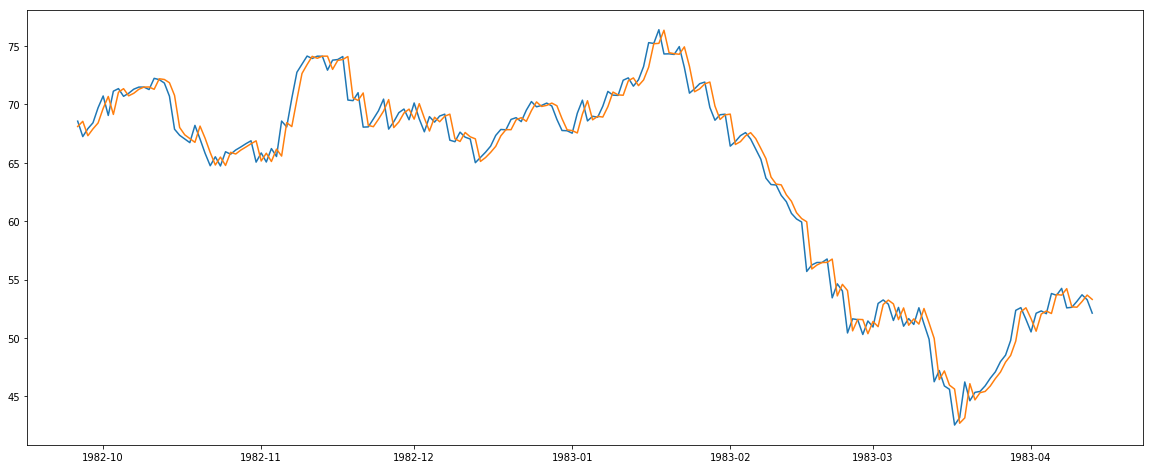

In [205]:
#pdq (0,1,1)
test_range = 200
test_result = []
test_prediction = []
date_for_prediction = ts[-(test_range):].index
for i in range(test_range):
    train_data = ts[:-(test_range-i)]
    #Combined Model
    model = ARIMA(train_data, order=(0, 1, 1))  
    results_ARIMA = model.fit(disp=-1)
    pre_data = results_ARIMA.predict(start=str(date_for_prediction[i]).split()[0],end=str(date_for_prediction[i]).split()[0],dynamic=True,typ='levels')
    test_prediction.append(pre_data.values[0])
#     plt.figure(figsize=(20,8))
#     plt.plot(ts_log_diff)
#     plt.plot(results_ARIMA.fittedvalues, color='red')
#     plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))
result_raw011 = ts[-(test_range):].to_frame()
result_raw011['prediction'] = test_prediction
plt.figure(figsize=(20,8))
plt.plot(result_raw011)
plt.savefig('ARIMA_new')

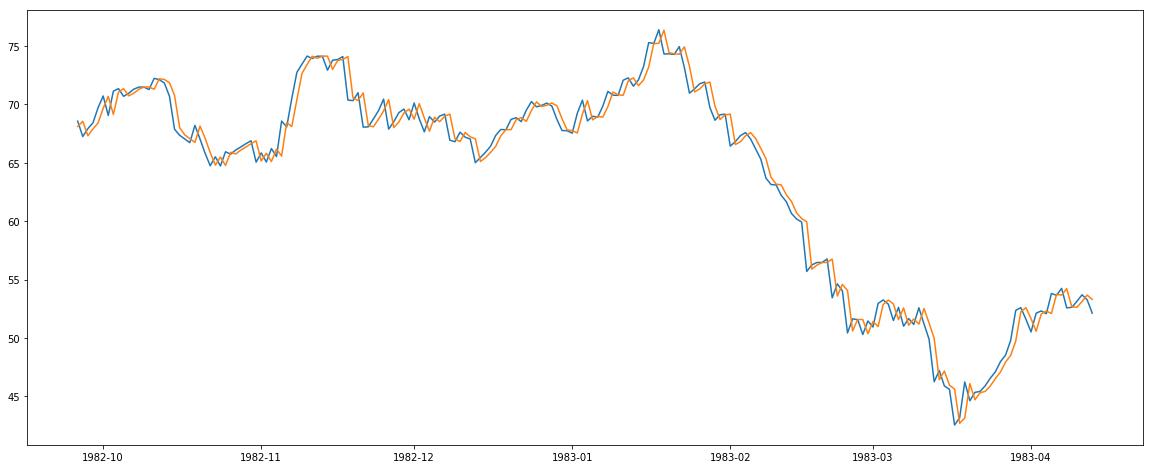

In [155]:
#pdq (1,1,0)
test_range = 200
test_result = []
test_prediction = []
date_for_prediction = ts[-(test_range):].index
for i in range(test_range):
    train_data = ts[:-(test_range-i)]
    #Combined Model
    model = ARIMA(train_data, order=(1, 1, 0))  
    results_ARIMA = model.fit(disp=-1)
    pre_data = results_ARIMA.predict(start=str(date_for_prediction[i]).split()[0],end=str(date_for_prediction[i]).split()[0],dynamic=True,typ='levels')
    test_prediction.append(pre_data.values[0])
#     plt.figure(figsize=(20,8))
#     plt.plot(ts_log_diff)
#     plt.plot(results_ARIMA.fittedvalues, color='red')
#     plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))
result_raw110 = ts[-(test_range):].to_frame()
result_raw110['prediction'] = test_prediction
plt.figure(figsize=(20,8))
plt.plot(result_raw110)

In [161]:
result_raw111.head()

,end_price,prediction,yesterday
1982-09-26,68.57,68.111671,NaN
1982-09-27,67.25,68.557384,68.57
1982-09-28,67.93,67.317594,67.25
1982-09-29,68.43,67.924286,67.93
1982-09-30,69.72,68.410423,68.43


In [158]:
result_raw111.tail()

,end_price,prediction
1983-04-09,52.62,52.649503
1983-04-10,53.13,52.643906
1983-04-11,53.69,53.115765
1983-04-12,53.27,53.662775
1983-04-13,52.12,53.287655


In [165]:
from sklearn.metrics import mean_squared_error
from math import sqrt
RMSE111 = round(sqrt(mean_squared_error(result_raw111['end_price'], result_raw111['prediction'])),4)
RMSE110 = round(sqrt(mean_squared_error(result_raw110['end_price'], result_raw110['prediction'])),4)
RMSE011 = round(sqrt(mean_squared_error(result_raw011['end_price'], result_raw011['prediction'])),4)
print("RMSE for p=1, d=1, q=1 is: ", RMSE111)
print("RMSE for p=1, d=1, q=0 is: ", RMSE110)
print("RMSE for p=0, d=1, q=1 is: ", RMSE011)

RMSE for p=1, d=1, q=1 is:  1.2309
RMSE for p=1, d=1, q=0 is:  1.2272
RMSE for p=0, d=1, q=1 is:  1.2272


In [157]:
result_raw111['end_price'].shift()

1982-09-26      NaN
1982-09-27    68.57
1982-09-28    67.25
1982-09-29    67.93
1982-09-30    68.43
1982-10-01    69.72
1982-10-02    70.73
1982-10-03    69.06
1982-10-04    71.14
1982-10-05    71.36
1982-10-06    70.70
1982-10-07    70.96
1982-10-08    71.31
1982-10-09    71.49
1982-10-10    71.49
1982-10-11    71.28
1982-10-12    72.24
1982-10-13    72.13
1982-10-14    71.84
1982-10-15    70.71
1982-10-16    67.88
1982-10-17    67.36
1982-10-18    67.05
1982-10-19    66.73
1982-10-20    68.21
1982-10-21    67.04
1982-10-22    65.81
1982-10-23    64.75
1982-10-24    65.52
1982-10-25    64.73
              ...  
1983-03-15    47.20
1983-03-16    45.88
1983-03-17    45.59
1983-03-18    42.53
1983-03-19    43.16
1983-03-20    46.22
1983-03-21    44.61
1983-03-22    45.33
1983-03-23    45.41
1983-03-24    45.89
1983-03-25    46.54
1983-03-26    47.09
1983-03-27    47.96
1983-03-28    48.52
1983-03-29    49.78
1983-03-30    52.36
1983-03-31    52.59
1983-04-01    51.59
1983-04-02    50.51


In [159]:
result_raw_test = result_raw111

In [160]:
result_raw_test['yesterday']= result_raw111['end_price'].shift()

In [162]:
result_raw_test.dropna(inplace=True)

In [166]:
RMSE111_yesterday = round(sqrt(mean_squared_error(result_raw111['end_price'], result_raw111['yesterday'])),4)

In [167]:
RMSE111_yesterday

1.2318

In [182]:
len(result_raw111)

199

In [183]:
result_raw111['date'] = list(date_transfer_df[-199:]['date'])

In [185]:
result_raw111.to_csv('arima_prediction.csv', index=False)

In [184]:
result_raw111.head()

,end_price,prediction,yesterday,date
1982-09-27,67.25,68.557384,68.57,2018年5月1日
1982-09-28,67.93,67.317594,67.25,2018年5月2日
1982-09-29,68.43,67.924286,67.93,2018年5月3日
1982-09-30,69.72,68.410423,68.43,2018年5月4日
1982-10-01,70.73,69.657517,69.72,2018年5月7日
